In [8]:
import cv2
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np

In [9]:
IN_PATH = Path('/project/volume/data/in/EmoReact')
LABELS_PATH = Path('/project/volume/data/in/EmoReact/EmoReact_V_1.0/Labels/')
ORIG_FOLDERS = ['Test', 'Train', 'Validation']
LABEL_FILES = ['test_labels.text', 'train_labels.text', 'val_labels.text']

LABELS = ['Curiosity', 'Uncertainty', 'Excitement', 'Happiness', 'Surprise', 'Disgust', 'Fear', 'Frustration']

BASE_PATH = Path('/project/volume/data/out/EmoReact')

VIDEO_PATHS = list(BASE_PATH.rglob('*.mp4'))
VIDEO_PATHS_STR = [str(path) for path in VIDEO_PATHS]

IMAGE_PATHS = list(BASE_PATH.rglob('*.jpg'))
IMAGE_PATHS_STR = [str(path) for path in IMAGE_PATHS]

In [10]:
def remove_ipynb_checkpoints(path):
    for checkpoint_dir in Path(path).rglob('.ipynb_checkpoints'):
        print("Removing directory:", checkpoint_dir)
        for file in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, file)
            os.unlink(file_path)
        os.rmdir(checkpoint_dir)

In [11]:
remove_ipynb_checkpoints(BASE_PATH)
remove_ipynb_checkpoints(IN_PATH)

In [7]:
def create_folders():
    print(f"[INFO] Creating folders for labels ...")

    for label in LABELS:
        label_path = BASE_PATH / Path(label)
        if not label_path.exists():
            label_path.mkdir(parents=True, exist_ok=True)

def read_labels():
    print(f"[INFO] Creating dataframes for labels ...")

    df_train, df_test, df_val = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for label in LABEL_FILES:
        path = LABELS_PATH / Path(label)
        df = pd.read_csv(str(path), header=None)
        df = df.drop(columns=[df.columns[-1]])
        df.columns = LABELS
        if 'train_labels.text' in label:
            df_train = pd.concat([df_train, df], ignore_index=True)
        elif 'test_labels.text' in label:
            df_test = pd.concat([df_test, df], ignore_index=True)
        elif 'val_labels.text' in label:
            df_val = pd.concat([df_val, df], ignore_index=True)

    return df_train, df_test, df_val

In [180]:
create_folders()

[INFO] Creating folders for labels ...


In [181]:
df_train, df_test, df_val = read_labels()

print(df_train.sum())

[INFO] Creating dataframes for labels ...
Curiosity      148
Uncertainty    132
Excitement     144
Happiness      224
Surprise       114
Disgust         60
Fear            17
Frustration     53
dtype: int64


In [183]:
def create_sets():
    for folder in tqdm(ORIG_FOLDERS):
        folder_path = IN_PATH / Path('EmoReact_V_1.0/Data') / folder
        videos = list(folder_path.rglob('*.mp4'))
        if 'Train' in folder:
            df = df_train
        elif 'Test' in folder:
            df = df_test
        elif 'Validation' in folder:
            df = df_val
        else:
            continue

        for file_idx, file in enumerate(videos):
            file_path = Path(file)
            labels = [col for col, val in df.loc[file_idx].items() if val == 1]
            for label in labels:
                destination_folder = BASE_PATH / Path(label)
                destination_folder.mkdir(exist_ok=True, parents=True)
                destination_file = destination_folder / file_path.name
                if not destination_file.exists() and file_path.exists():
                    shutil.copy(str(file_path), str(destination_folder))
                    
        if folder_path.exists() and folder_path.is_dir():
            shutil.rmtree(folder_path)

In [184]:
create_sets()

100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.38s/it]


In [194]:
def extract_frames():
    print(f"[INFO] Extracting frames for {len(VIDEO_PATHS_STR)} videos ...")
    for video in tqdm(VIDEO_PATHS):
        cap = cv2.VideoCapture(str(video))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        nbr_frames = int(total_frames * 0.2)

        for frame_idx in range(nbr_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            _, frame = cap.read()
            frame_file_name = Path(str(video.stem) + f'_frame_{frame_idx}.jpg')
            frame_path = str(video.parent / frame_file_name)
            if not os.path.exists(str(frame_path)):
                cv2.imwrite(frame_path, frame)
    
        cap.release()
        if os.path.exists(video):
            os.remove(video)

In [197]:
extract_frames()

[INFO] Extracting frames for 2304 videos ...


100%|███████████████████████████████████████████████████████████████████| 2304/2304 [42:20<00:00,  1.10s/it]


In [198]:
from mediapipe import Image
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [199]:
model_path_detect = '/project/volume/models/blaze_face_short_range.tflite'
base_options_detect = python.BaseOptions(model_asset_path=model_path_detect)
options_detect = vision.FaceDetectorOptions(base_options=base_options_detect)
detector_detect = vision.FaceDetector.create_from_options(options_detect)

model_path_mesh = '/project/volume/models/face_landmarker.task'
base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
options_mesh = vision.FaceLandmarkerOptions(base_options=base_options_mesh, 
                                            output_face_blendshapes=False, 
                                            output_facial_transformation_matrixes=True, 
                                            num_faces=1)
detector_mesh = vision.FaceLandmarker.create_from_options(options_mesh)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1717451156.721876   27081 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [200]:
def read_mp_cv2_image(image_path):
    return Image.create_from_file(str(image_path)), cv2.imread(str(image_path))

In [203]:
def crop_faces():
    for file in tqdm(IMAGE_PATHS):
        img_mp, img_cv2 = read_mp_cv2_image(file)
        detection_results = detector_detect.detect(img_mp)
        file_stem = str(file.stem)
        file_parent = file.parent

        for d_idx, d in enumerate(detection_results.detections):
            bbox = d.bounding_box
            origin_x, origin_y, width, height = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
            face = img_cv2[origin_y:origin_y + height, origin_x:origin_x + width]

            frame_file_name = f"{file_stem}_face_{d_idx}.jpg"
            frame_path = file_parent / frame_file_name

            if not frame_path.exists():
                cv2.imwrite(str(frame_path), face)
            
        if file.exists():
            os.remove(file)

In [216]:
crop_faces()

100%|████████████████████████████████████████████████████████████████████| 54920/54920 [27:20<00:00, 33.48it/s]


#### Show samples

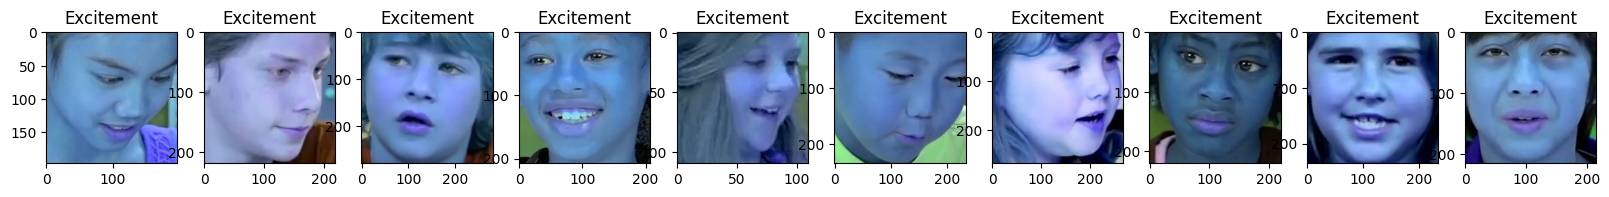

In [36]:
fig = plt.figure(figsize=(20,20))

for i in range(10):

    fig.add_subplot(1, 10, i + 1)
    plt.imshow(np.array(cv2.imread(str(IMAGE_PATHS[i]))), cmap='gray')
    label = Path(IMAGE_PATHS[i]).parent.name
    plt.title(label)

plt.show()

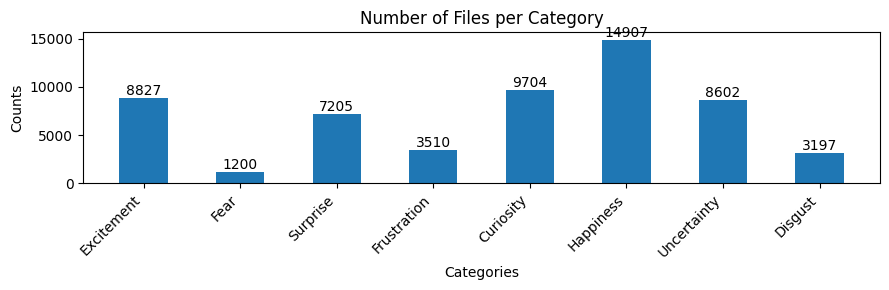

In [7]:
from collections import Counter
from pathlib import Path

def get_distribution():
    nbr_per_cat = Counter(Path(file).parent.name for file in IMAGE_PATHS)

    categories = list(nbr_per_cat.keys())
    counts = list(nbr_per_cat.values())

    plt.figure(figsize=(9, 3))
    bars = plt.bar(categories, counts, width=0.5)

    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Number of Files per Category')
    plt.xticks(rotation=45, ha='right')

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

get_distribution()

In [20]:
from skimage.feature import hog

In [21]:
def to_grayscale(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_image(img, size):
    return cv2.resize(img, (size,size))

In [22]:
IMAGE_PATHS = list(BASE_PATH.rglob('*.jpg'))
IMAGE_PATHS_STR = [str(path) for path in IMAGE_PATHS]

In [23]:
def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [24]:
def extract_hog_features():
    print("[INFO] Extraction HOG features ...")
    hog_data = []
    hog_labels = []

    for file in tqdm(IMAGE_PATHS):
        img = to_grayscale(str(file))
        img = resize_image(img, 32)
        
        # extract hog feature descriptor
        fd1 = hog(img, orientations=7, pixels_per_cell=(8, 8),
                  cells_per_block=(4, 4), 
                  block_norm='L2-Hys',
                  transform_sqrt=False,
                  feature_vector=True)

        label = Path(file).parent.name
        hog_labels.append(label)
        hog_data.append(fd1)

    hog_data = np.array(hog_data)
    hog_labels = np.array(hog_labels)
    print("[INFO] Number of features ...", str(hog_data.shape[1]))
    print("[INFO] Number of labels ...", str(hog_labels.shape[0]))
    return hog_data, hog_labels

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

In [26]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n")
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n")

In [1]:
hog_data, hog_labels = extract_hog_features()

x_train, x_test, y_train, y_test = train_test_split(hog_data, hog_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1], 'C': [1]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_hog = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)

pickle.dump(best_estimator_hog, open('/project/volume/models/EmoReact/hog_model.p', 'wb'))

print_score(best_estimator_hog, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_hog, x_train, y_train, x_test, y_test, train=False)

NameError: name 'extract_hog_features' is not defined

In [1]:
from mediapipe import Image
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import mediapipe as mp

In [ ]:
def read_mp_cv2_image(image_path):
    return Image.create_from_file(str(image_path)), cv2.imread(str(image_path))

def colortogray(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return imgray

def resizeImage(image, size):
    return cv2.resize(image, (size,size))

In [ ]:
def extract_landmarks():
    lm_labels = []
    lm_data = []

    for file in tqdm(IMAGE_PATHS):
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 128)
        rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
        detection_result = detector_mesh.detect(rgb_frame)

        if detection_result.face_landmarks:
            lm_array = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.face_landmarks[0]]).flatten()
            lm_labels.append(file.parent.name)
            lm_data.append(lm_array)

    lm_labels = np.array(lm_labels)
    lm_data = np.array(lm_data)

    return lm_data, lm_labels

In [ ]:
lm_data, lm_labels = extract_landmarks()

x_train, x_test, y_train, y_test = train_test_split(lm_data, lm_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_landmark = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_landmark, open('/project/volume/models/lm_model.p', 'wb'))

print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=False)

## Pure images

In [ ]:
def pure_pixels():
    pixel_labels = []
    pixel_data = []

    for file in tqdm(IMAGE_PATHS):     
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 128)
        
        pixel_labels.append(file.parent.name)
        pixel_data.append(np.array(img_cv2).flatten())

    pixel_labels = np.array(pixel_labels)
    pixel_data = np.array(pixel_data)

    return pixel_data, pixel_labels

In [ ]:
pixel_data, pixel_labels = pure_pixels()

x_train, x_test, y_train, y_test = train_test_split(pixel_data, pixel_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_pixel = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_pixel, open('/project/volume/models/pixel_model.p', 'wb'))

print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=False)

## K-fold cross validation

In [ ]:
n_splits_values = [3, 5, 10]

In [ ]:
classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

modes = {'hog': best_estimator_hog, 
         'pixel': best_estimator_pixel,
         'landmark': best_estimator_landmark
        }

for mode, model in modes.items():
    print(mode)
    for n_splits in n_splits_values:
        cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
        scores = cross_val_score(model, lm_data, lm_labels, scoring='accuracy', cv=cv, n_jobs=-1)
        print(f"{n_splits}-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")